# Section 1: Image Generation

This section consists of processing the raw data and store the data locally in image format. This markdown block consists of all the steps and the justification beind the steps.

1. <strong>Random Seed</strong>

  We first import the Numpy module and the we set a random seed for the reproducibility of the results.

2. <strong>Load the json file</strong>

  For loading the Json file, We're using python's built-in `json` moudle. We Specify the path to the json and then we use the `open` function to load the file. We read the data in a variable `raw_data` using the json's `load` method. Now the `raw_data` is of type `list` containing `dictionaries`.


3. <strong>Process the Dictionaries inside the `raw_data`</strong>

  For every dictionary object in the list, we extract some basic information like
  - label
  - color_mode
  
  After that we do 2 types of processing to the images, i.e if the `color_mode` is `gray` or if the `color_mode` is `R` (which corresponds to an RGB image).
  
  - In case of gray images, we first get the pixel values, Then we cast them to a numpy array, Then we calculate the reshapping index using the sqrt(len(pixel_array)). This will give us the number which can be utilized to reshape the image to a perfect square. For example sqrt(784) gives us 28 which tells us that the array can be reshaped to (28 x 28). We reshape the image and then we append it with the corresponding label to a list `data_in_list` in form of tuple. i.e (label, image) will be appended to the list.
  
  - In case of RGB images, we first get the pixel list for each 'R', 'G', 'B' channels, we then calculate the reshaping index for each channel individually using the same square_root methodology mentioned above and then reshape each channel. After that we use the Numpy's `dstack` method to merge the 3 channels in the format of BGR. Why BGR? Because by convention OpenCV loads the image in the format of BGR, whereas PIL loads the image in the format of RGB. I'm using OpenCV so i stacked them in the format of BGR just to stick with the convention. Then we again append the prcessed image in the list as mentioned above.
  
  - Now we have a list of tuples containing the label and the image. We first shuffle the list using the `shuffle` method belonging to `randome` module of python.
  
  - The next step is to create some directories. I'm storing the data in the format of keras's `ImageDataGenerator` which is discussed in detail in the next section. The directory structure becomes like
  ```
  data/images/
    ├── test
    └── train
  ```  
  
  - Next we use the sklearn's `train_test_spilt` method which takes in the `data_in_list` and spits out 2 list named `train`, `test`. The `test_split` is 10% of the total data and the `random_state` is set as well for the reproduction of the split. Note that the data in `train` and `test` is the same as (label, image).
  
  - Now once we have our train and test lists, we can utilize them to save our data locally. We are using 2 loops (one for train and one for test) with the same logic. First we have a counter variable which we will use to name the imagew. Now for every label and image, we first check for if there is a directory named as label under the train directory. If there isn't one, we simply create one named the corresponding label. I'm using f-string literal for string formating. Once the directory is created, we simply save that image in the corresponding label directory using same f-string literal approach. At the end we increment the counter by 1. The following step generated a directory structure as follows
  
  `$tree -d ./data/images` report
   ```
   data/images/
    ├── test
    │   ├── Ankle boot
    │   ├── automobile
    │   ├── Bag
    │   ├── bird
    │   ├── Sandal
    │   └── truck
    └── train
        ├── Ankle boot
        ├── automobile
        ├── Bag
        ├── bird
        ├── Sandal
        └── truck
   ```
   
   All the images are present in the corresponding directories. `-d` flag only reports directories and to be honest complete output of the tree will not fit the cell. Trust me on this one, The data is present in the directories :)
   
4) <strong>Class Weights Balancing</strong>
    
  Additionaly we will do one more step which is to calculate the class weights. Why are we calculating the class weights? The problem that i was facing was that the model wasn't able to classify some of the classes properly. When i analysed the problem, i found out that some of the classes like `automobile` contained only 443 samples in training set. So the data was heviely imbalanced. My solution to this problem was to calculate the `class_weights`. Model during its training time will be more bias to these classes and the problem of misclassifying the class will resolve.

In [3]:
import numpy as np
np.random.seed(42)

In [2]:
# Import some required Libraries
from os import makedirs, listdir
from json import load
from cv2 import imwrite
from math import sqrt
from sklearn.model_selection import train_test_split
import random
from pprint import pprint

In [3]:
# Path to json file
path = "./data/gen_img_data.json"

# Load the json data
with open(path) as json_file:
    raw_data = load(json_file)

In [4]:
data_in_list = list()

# For every dictionary in `raw_data`
for obj in raw_data:

    # Get the Label of the Image
    label = list(obj)[0]
    # Get the Color_Mode of the image
    color_mode = list(obj[label])[0]

    # Case 1: If the image is gray
    if color_mode == 'grey':

        # Get the pixel List casted to numpy array
        pixels = np.array(obj[label][color_mode])

        # Reshape the 1D Array to a 2D array to form an image
        reshape_index = int(sqrt(pixels.shape[0]))
        image = np.reshape(pixels, (reshape_index, reshape_index))

    # Case 2: If the image is Colored
    elif color_mode == 'R':

        # Get Red Channel, cast to numpy array and Reshape 1D -> 2D
        r_pixels = np.array(obj[label]['R'])
        reshape_index = int(sqrt(r_pixels.shape[0]))
        r_pixels = np.reshape(r_pixels, (reshape_index, reshape_index))

        # Get Green Channel, cast to numpy array and Reshape 1D -> 2D
        g_pixels = np.array(obj[label]['G'])
        reshape_index = int(sqrt(g_pixels.shape[0]))
        g_pixels = np.reshape(g_pixels, (reshape_index, reshape_index))

        # Get Blue Channel, cast to numpy array and Reshape 1D -> 2D
        b_pixels = np.array(obj[label]['B'])
        reshape_index = int(sqrt(b_pixels.shape[0]))
        b_pixels = np.reshape(b_pixels, (reshape_index, reshape_index))

        # Combine the 3 channels
        image = np.dstack((b_pixels, g_pixels, r_pixels))

    # Append the label and image in the list
    data_in_list.append((label, image))

In [5]:
# Some statistics

# We use `list comprehension` to get the labels from the `data_in_list` and we use
# numpy's `unique` method to calculate the count of the class
total_class_count = np.unique(
    [data_point[0] for data_point in data_in_list], return_counts=True)
print("Total Class Counts:\n")
pprint(dict(zip(total_class_count[0], total_class_count[1])))

Total Class Counts:

{'Ankle boot': 6000,
 'Bag': 6000,
 'Sandal': 1201,
 'automobile': 501,
 'bird': 5000,
 'truck': 5000}


In [6]:
# Shuffle the data list using the seed for reproduction of the results
random.Random(42).shuffle(data_in_list)

In [7]:
# Make "images", "train", "test" directories
try:
    makedirs("./data/images")
    makedirs("./data/images/train")
    makedirs("./data/images/test")
except:
    pass

In [8]:
# Make a train_test split of the data with test_size of 10%. We also set a random state to reproduce the split
train, test = train_test_split(data_in_list, test_size=0.1, random_state=42)

In [9]:
# Check train, test statistics
train_class_count = np.unique([data_point[0]
                               for data_point in train], return_counts=True)
test_class_count = np.unique([data_point[0]
                              for data_point in test], return_counts=True)

print("Train Counts:\n")
pprint(dict(zip(train_class_count[0], train_class_count[1])))

print("\n\nTest Counts:\n")
pprint(dict(zip(test_class_count[0], test_class_count[1])))

Train Counts:

{'Ankle boot': 5424,
 'Bag': 5408,
 'Sandal': 1065,
 'automobile': 444,
 'bird': 4494,
 'truck': 4496}


Test Counts:

{'Ankle boot': 576,
 'Bag': 592,
 'Sandal': 136,
 'automobile': 57,
 'bird': 506,
 'truck': 504}


In [10]:
# Save the train files locally based on the label

# Counter is used for naming of the image files
counter = 1

# For every label and image in the train set
for label, image in train:

    # Check if the label directory exists under the train directory
    try:
        # Make the label directory under train
        makedirs(f"./data/images/train/{label}")
    except:
        pass

    # Write the image under the label directory
    imwrite(f"./data/images/train/{label}/{counter}.jpg", image)
    counter += 1

In [11]:
# Save the test files locally based on the label

# Counter is used for naming of the image files
counter = 1

# For every label and image in test set
for label, image in test:

    # Check if the label directory exists under the test directory
    try:
        # Make the label directory under test
        makedirs(f"./data/images/test/{label}")
    except:
        pass

    # Write the image under the label directory
    imwrite(f"./data/images/test/{label}/{counter}.jpg", image)
    counter += 1

In [12]:
# Class balancing
from sklearn.utils.class_weight import compute_class_weight

# Get the unique classes
classes = np.array(listdir("./data/images/train/"))

# Calculate the class_weights
weights = compute_class_weight('balanced', classes, np.array(
    [data_point[0] for data_point in train]))

In [13]:
# Check the calculated weights and cast them to a dictionary for now
weights = dict(zip(classes, weights))
pprint(weights)

{'Ankle boot': 0.655451081612586,
 'Bag': 0.6573902859960552,
 'Sandal': 3.3381846635367762,
 'automobile': 8.007132132132131,
 'bird': 0.7910918261385551,
 'truck': 0.7907399169632265}


So we have the weights calculated based on the number of samples per class in the train set. The summary is as follows

| Class      | Training Samples | Calculated weights |
|------------|------------------|--------------------|
| Ankle boot |       5424       |        0.66        |
| Bag        |       5408       |        0.66        |
| Sandal     |       1065       |        3.34        |
| automobile |        444       |        8.01        |
| bird       |       4494       |        0.79        |
| truck      |       4496       |        0.79        |

We can clearly see that the automobile class is assigned with the heaviest weight amont all others because of the less number of data points.

# Section 2: Image Augmentation and Preprocessing

In this section, i'm going to use the keras's `ImageDataGenerator` module. I'm using this module for multiple reasons as it will help me in the following

  - Efficient on the memory as the images will be loaded to the RAM in batches.
  - Easy to use augmentation as it includes functions like 
      - Rescaling
      - Horizontal and Vertical Flip
      - Random Rotation
  - Train/Validation Split
  
1. <strong>Get the file path and get the classes</strong>
   
   We first specify the train directory path and the test directory path. Then we use one of the directories to capture the unqie classes using os module's `listdir` which will be used later. 
   
   
2. <strong>Create a train_datagen object</strong>
   
   I'm creating an ImageDataGenerator, `train_datagen` object where i specify the object to
     - Rescale the images
     - Apply Horizontal flip Augmentation
     - Apply Vertical Flip Augmentation
     - Apply Random Rotation Augmentation with thresh of 0.2
     - Validation Split of 25%
   
   Note that i'm only using augmentation techniques that make sense. For example it doesn't make any sense to apply Vertical Flip to MNIST Dataset.
   
   Using the above created `ImageDataGenerator` object, i use the `flow_from_directory` method in which i specify the 
   
   - Path to the data
   - <strong>target_size</strong> I have 2 target size as of (28, 28) and (32, 32) so i have used an average target size of (30, 30). I have not used anyother size as using a large size will blur the images and using a very small size will effect the training as well.
   - <strong>batch_size</strong> I'm using a batch size of 32 for training and 16 for validation as i have a low_end GPU (GeForce 940M)
   - <strong>class_mode</strong> is set to `categorical`
   - <strong>classes</strong> is set to the `classes` variable containing the classes.
   - <strong>subset</strong> is set to `training` in case of the `train_generator` and `validation` in case of the `validation_generator`.
   - <strong>color_mode</strong> is set to `grayscale` as i will be training the model on grayscale images.
   
   Note that there is a difference between train, validation and test. `Validation` data is a subset of the `train` data and we use it for the validation of the model's performance where as `Test` data is used for model's evaluation.
   
   
   <div style="text-align:center"><img src="https://miro.medium.com/max/776/1*Nv2NNALuokZEcV6hYEHdGA.png" width="50%" height="25%" /></div>
   
   Finally we create a seperate generator for test set in which we only rescale the image. This Generator will be used later on in the evaluation section.

In [14]:
# Import required Libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
train_path = "./data/images/train/"
test_path = "./data/images/test/"

In [16]:
# Create ImageDataGenerator Object

train_datagen = ImageDataGenerator(
    rescale=1./255,  # To rescale between (0, 1)
    horizontal_flip=True,  # Will apply horizontal augmentation
    vertical_flip=True,  # Will apply  vertical augmentation
    rotation_range=0.2,  # Will apply rotation augmentation
    validation_split=0.25  # Will make a Validation Split
)

In [17]:
# Create train_generator

train_generator = train_datagen.flow_from_directory(
    train_path,  # Path to data
    target_size=(30, 30),  # Average target size (32 + 28)/2 = 30
    batch_size=32,  # Batch size
    class_mode='categorical',  # Categorical Class mode
    classes=list(classes),  # Classes
    subset='training',  # Training Subset
    color_mode='grayscale',
    seed=42
)

Found 15999 images belonging to 6 classes.


In [18]:
# Create validation_generator

validation_generator = train_datagen.flow_from_directory(
    train_path,  # Path to data
    target_size=(30, 30),  # Average target size
    batch_size=16,  # Batch Size
    class_mode='categorical',  # Categorical Class mode
    classes=list(classes),  # Classes
    subset='validation',  # Validation Subset
    color_mode='grayscale',
    seed=42
)

Found 5332 images belonging to 6 classes.


In [19]:
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_path,  # Path to data
    target_size=(30, 30),  # Average target size (32 + 28)/2 = 30
    batch_size=8,  # Batch size
    class_mode='categorical',  # Categorical Class mode
    classes=list(classes),  # Classes
    color_mode='grayscale'
)

Found 2371 images belonging to 6 classes.


In [20]:
# See if the class indices are equal for every split
train_generator.class_indices == validation_generator.class_indices == test_generator.class_indices

True

In [21]:
# Get the class indice with the corresponding weight value
# We will use dictionary for this purpose to get the class indices w.r.t class_weight
class_weights = {train_generator.class_indices[key]: weights[key]
                 for key in train_generator.class_indices.keys()}

In [22]:
# Class weights with class indices
class_weights

{0: 0.6573902859960552,
 1: 3.3381846635367762,
 2: 8.007132132132131,
 3: 0.7910918261385551,
 4: 0.7907399169632265,
 5: 0.655451081612586}

# Section 3: Training Phase

In this section we are going to build a model and train is using the data we processed above.

1. We build a custome `Squential` model which consists of 3 Convolutional blocks for feature extraction.

  - The First Convolutional block contains a `Conv2D` layer with 128 kernels of size (3 x 3). We use `relu` as the activation function. After that we apply `MaxPooling2D` layer with size (2 x 2) to reduce the image size which can help prevent the `Curse Of Dimentionality`.
  
  - The Second Convolutional block contains a `Conv2D` layer with 64 kernels of size (3 x 3). We use `relu` as the activation function. After that we apply `MaxPooling2D` layer with size (2 x 2) for the same reason.
  
  - The third Convolutional block contains a `Conv2D` layer with 32 kernels of size (3 x 3). We use `relu` as the activation function. After that we apply `MaxPooling2D` layer with size (2 x 2).
  
  - We then use the `Flatten` layer to convert to 1D Vector.
  
  - We have a `Dense` layer with 128 neurons with an activation of `relu`
  
  - We then use a `Dropout` layer for regularization.
  
  - We then have a Classification `Dense` Layer of 6 neurons (Number of classes) with an activation of `softmax` which will return the probability vector containing probabilities of each class.
  
  - We then compile the model with `loss=categorical_crossentropy` and `optimizer=adam`.
  
  - We are also generating the `callbacks` list for the purpose of saving the best weights.
  
  - We check for if there is a `checkpoints` directory. If there is no directory, we create one and we save the models in that directory in `hdf5` format.
  
2. We are going to use the `fit_generator` method as we have the data in the format of `ImageDataGenerator`.

  - We save the history as the model is being trained. 
  
  - `steps_per_epoch` is set to `train_data.n // train_data.batch_size`. This is a formal way to chose a step size. We chose the ratio of total number of samples and the size of the batch size.
  
  - `validation_steps` follows the same strategy of `validation_generator.n // validation_generator.batch_size`.
  
  - We then used the `history` to plot the `training_accuracy` against `validation_accuracy` and `training_loss` against `validation_loss` to see if the model is overfitting or not.

In [4]:
# Import required libararies

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [24]:
# Define a custom model


def my_model(input_shape, num_classes):

    # We will use Sequential Model
    model = Sequential()

    # First Convolutional Block
    model.add(Conv2D(128, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third Convolutional Block
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Classification Block
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(1024))
    model.add(Activation('relu'))
    # Add regularization
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # Create checkpoints directories
    try:
        # If directory not found
        makedirs(f"./checkpoints")
    except Exception as e:
        # If directory already exists
        pass

    # Define Model checkpoints and callbacks_list
    filepath = "./checkpoints/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
    checkpoint = ModelCheckpoint(
        filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [EarlyStopping(
        monitor='val_accuracy', patience=5), checkpoint]

    return model, callbacks_list

In [28]:
# Get the model and callbacks_list
model, callbacks_list = my_model(train_generator.image_shape, len(classes))

In [26]:
# Check summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 128)       1280      
_________________________________________________________________
activation (Activation)      (None, 28, 28, 128)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        73792     
_________________________________________________________________
activation_1 (Activation)    (None, 12, 12, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 32)          1

In [29]:
# Train the model
history = model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    verbose=1,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    callbacks=callbacks_list,
    class_weight=class_weights,
    use_multiprocessing=True
)

Epoch 1/50
498/499 [============================>.] - ETA: 0s - loss: 0.7314 - accuracy: 0.6901
Epoch 00001: val_accuracy improved from -inf to 0.85454, saving model to ./checkpoints/weights-improvement-01-0.85.hdf5
499/499 [==============================] - 167s 334ms/step - loss: 0.7304 - accuracy: 0.6905 - val_loss: 0.4485 - val_accuracy: 0.8545
Epoch 2/50
498/499 [============================>.] - ETA: 0s - loss: 0.5130 - accuracy: 0.7848
Epoch 00002: val_accuracy improved from 0.85454 to 0.88326, saving model to ./checkpoints/weights-improvement-02-0.88.hdf5
499/499 [==============================] - 137s 274ms/step - loss: 0.5125 - accuracy: 0.7851 - val_loss: 0.3455 - val_accuracy: 0.8833
Epoch 3/50
498/499 [============================>.] - ETA: 0s - loss: 0.4635 - accuracy: 0.8174
Epoch 00003: val_accuracy did not improve from 0.88326
499/499 [==============================] - 139s 278ms/step - loss: 0.4629 - accuracy: 0.8177 - val_loss: 0.3312 - val_accuracy: 0.8741
Epoch 4/5

In [30]:
# For plotting
import matplotlib.pyplot as plt

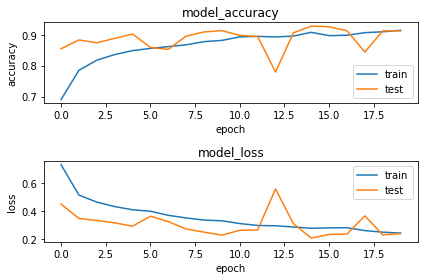

In [31]:
# Plot the history
_, (ax1, ax2) = plt.subplots(2)
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title(f'model_accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='best')
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title(f'model_loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='best')
plt.tight_layout()

# Section 4: Prediction Phase

Now that we are done with the training phase, we are ready to make predictions.

1) As we were saving the model's checkpoints, we will load the model locally from the drive. My selection would be the second last weights for no specific reason. We will use kera's, models' `load_model` method for the purpose. We define the path to the checkpoints of our choice and then we load the model.

2) We still have our `test_generator` unused so we will make the predictions on the test generator via the method `predict_generator`. This will provide us with a list of softmax probability vector for each class. As we are only concerned with the class of max probability, we use the numpy's `argmax` method to select the heights probability.

In [5]:
from tensorflow.keras.models import load_model

In [33]:
path_to_model = "./checkpoints/weights-improvement-15-0.93.hdf5"
model = load_model(path_to_model)

In [34]:
# Make predicions
Y_pred = model.predict_generator(
    test_generator, test_generator.n // test_generator.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

# Section 5: Model Evaluation Phase

After making the predictions, we are ready to check our model's evaluation based on the predictions. For this we will use the `confusion_matrix` and `classification_report`.

1) We simply pass the `test_generator.classes` and the `y_pred` of our model to the confusion matrix which generates the confusion matrix.

2) We generate the classification report then. First we get the `target_names` using the `test_generator.class_indices`. Then we simply pass ont `test_generator.classes`, `y_pred`, `target_names` to the `classification_report` method from `sklearn.metrics`

In [35]:
from sklearn.metrics import classification_report, confusion_matrix

In [36]:
print('Confusion Matrix:\n')
print(confusion_matrix(test_generator.classes, y_pred))

Confusion Matrix:

[[153  31  23 113 117 155]
 [ 32   9   6  33  29  27]
 [ 11  10   1  13  11  11]
 [119  25  32 100 113 117]
 [126  32  23 101  85 137]
 [150  34  33 116 117 126]]


In [37]:
print('Classification Report:\n')
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes,
                            y_pred, target_names=target_names))

Classification Report:

              precision    recall  f1-score   support

         Bag       0.26      0.26      0.26       592
      Sandal       0.06      0.07      0.06       136
  automobile       0.01      0.02      0.01        57
        bird       0.21      0.20      0.20       506
       truck       0.18      0.17      0.17       504
  Ankle boot       0.22      0.22      0.22       576

    accuracy                           0.20      2371
   macro avg       0.16      0.15      0.16      2371
weighted avg       0.21      0.20      0.20      2371



# Conclusion

Summary of the task is

  - We load the Json
  - We Process the image based on the color mode
  - We split the data in train-test
  - We then compute the class weights
  - We store the images locally
  - We load the images using the Image data generator
  - We get the train-validation and test generator
  - We apply augmentation on the train and validation set.
  - We train the custom model using the callback in which we define the check points and early stopping.
  - We make predictions using the test generator
  - We evaluate the model using the confusion matrix and classification report.
  
We see that the model is classifying just a considerable amount which can be resolved using the `hyper-parameter tunning`. We can use the grid search for this purpose and tune the parameters like `learning rate`, `loss` and `optimizers`. The problem is that the grid search will take some great amount of time. But the results can be improved.

# Prediction for Arbisoft Evaluation

In [3]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from json import load
from math import sqrt
from os import listdir

In [4]:
# Get the unique classes
classes = np.array(listdir("./data/images/train/"))


def predict(path):
    '''
        This method assumes the data to be in a json file just like the dataset. 
        It will load a model locally that was stored after training and use it to predict the class.
    '''

    # Load the locally saved model
    path_to_model = "./checkpoints/weights-improvement-15-0.93.hdf5"
    model = load_model(path_to_model)

    # Load the json data
    with open(path) as json_file:
        raw_data = load(json_file)

    # For every dictionary in `raw_data`
    for obj in raw_data:

        # Get the Label of the Image
        label = list(obj)[0]
        # Get the Color_Mode of the image
        color_mode = list(obj[label])[0]

        # Case 1: If the image is gray
        if color_mode == 'grey':

            # Get the pixel List casted to numpy array
            pixels = np.array(obj[label][color_mode])

            # Reshape the 1D Array to a 2D array to form an image
            reshape_index = int(sqrt(pixels.shape[0]))
            image = np.reshape(pixels, (reshape_index, reshape_index))

            # Resize
            image = cv2.resize(image.astype('float32'), (30, 30))
            # Expand the dims to make a Rank 4 Tensor
            image = np.expand_dims(image, axis=0)
            image = np.expand_dims(image, axis=3)

        # Case 2: If the image is Colored
        elif color_mode == 'R':

            # Get Red Channel, cast to numpy array and Reshape 1D -> 2D
            r_pixels = np.array(obj[label]['R'])
            reshape_index = int(sqrt(r_pixels.shape[0]))
            r_pixels = np.reshape(r_pixels, (reshape_index, reshape_index))

            # Get Green Channel, cast to numpy array and Reshape 1D -> 2D
            g_pixels = np.array(obj[label]['G'])
            reshape_index = int(sqrt(g_pixels.shape[0]))
            g_pixels = np.reshape(g_pixels, (reshape_index, reshape_index))

            # Get Blue Channel, cast to numpy array and Reshape 1D -> 2D
            b_pixels = np.array(obj[label]['B'])
            reshape_index = int(sqrt(b_pixels.shape[0]))
            b_pixels = np.reshape(b_pixels, (reshape_index, reshape_index))

            # Combine the 3 channels
            image = np.dstack((b_pixels, g_pixels, r_pixels))

            # Resize
            image = cv2.resize(image.astype('float32'), (30, 30))
            # Change to grayscale
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # Expand the dims to make a Rank 4 Tensor
            image = np.expand_dims(image, axis=0)
            image = np.expand_dims(image, axis=3)

        print(classes[np.argmax(model.predict(image), axis=1)])

In [5]:
test = "./data/gen_img_data.json"

In [6]:
predict(test)

['Ankle boot']
['Sandal']
['Sandal']
['Ankle boot']
['Sandal']
['Sandal']
['Ankle boot']
['Bag']
['Bag']
['Bag']
['Sandal']
['Ankle boot']
['Sandal']
['Ankle boot']
['Bag']
['Sandal']
['Sandal']
['Sandal']
['Ankle boot']
['Sandal']
['Ankle boot']
['Ankle boot']
['Ankle boot']


KeyboardInterrupt: 